In [1]:
import numpy as np
import pandas as pd
from matplotlib import gridspec
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os

sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

## Read in catalog

In [58]:
###### REPLACE WITH YOUR FILE LOCATION #######
gnd_EZ = fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.data.fits')
gsd_EZ = fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.data.fits')

gnd_EZ_cat = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits'),
                    format = 'fits').to_pandas()
gsd_EZ_cat = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits'),
                    format = 'fits').to_pandas()

gnd_cat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Catalog/goodsn_3dhst.v4.4.cat',
                    format = 'ascii').to_pandas()
gsd_cat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Catalog/goodss_3dhst.v4.4.cat',
                    format = 'ascii').to_pandas()

masterlist = pd.read_pickle('../phot/master_template_list.pkl')

## Define some functions

In [65]:
def Phot_get(field, galaxy_id, masterlist):
    cat = catalog[catalog.id == galaxy_id]

    if field[1] == 'N':
        pre= 'N_'
        cat = gnd_cat[gnd_cat.id == galaxy_id]

    else:
        pre= 'S_'
        cat = gsd_cat[gsd_cat.id == galaxy_id]

    eff_wv = []
    phot_fl = []
    phot_er = []
    phot_num = []

    for i in cat.keys():
        if i[0:2] == 'f_':
            Clam = 3E18 / masterlist.eff_wv[masterlist.tmp_name == pre + i].values[0] **2 * 10**((-1.1)/2.5-29)
            if cat[i].values[0] > -99.0:
                eff_wv.append(masterlist.eff_wv[masterlist.tmp_name == pre + i].values[0])
                phot_fl.append(cat[i].values[0]*Clam)
                phot_num.append(masterlist.tmp_num[masterlist.tmp_name == pre + i].values[0])
        if i[0:2] == 'e_':
            if cat[i].values[0] > -99.0:
                phot_er.append(cat[i].values[0]*Clam)

    return np.array([eff_wv, phot_fl, phot_er])

def read_templates(wave, temps):
    templates = []

    for temp in temps:
        templ = Template(wave, temp)
        templ.set_fnu()
        templates.append(templ)

    return templates

class Template():
    def __init__(self,tempwv, tempflux):
        self.wave = tempwv
        self.flux = tempflux
        self.flux_fnu = None
        self.set_fnu()

    def set_fnu(self):
        self.flux_fnu = self.flux * self.wave**2 / 3.e18


def full_sed(z, coeffs, templates):
    TEMP =read_templates(template_wv,templates)                      
    NTEMP = len(TEMP)
    
    import astropy.units as u

    templ = TEMP
    tempflux = np.zeros((NTEMP, templ[0].wave.shape[0]))
    for i in range(NTEMP):
        tempflux[i, :] = templ[i].flux_fnu

    templz = templ[0].wave*(1+z)

    templf = np.dot(coeffs, tempflux)
    return templz, templf

In [41]:
templates = gnd_EZ['TEMPF'].data
template_wv =gnd_EZ['TEMPL'].data

In [66]:
def Generate_plot(Field, galaxy_ID):
    
    if Field[1] == 'N':
        coeffs = gnd_EZ['COEFFS'].data[galaxy_ID - 1]
        zgrid = gnd_EZ['ZGRID'].data 
        zchi2 = gnd_EZ['CHI2'].data[galaxy_ID - 1]
        zbest = gnd_EZ_cat.query('id == {0}'.format(galaxy_ID)).z500.values[0]
    
    else:
        coeffs = gsd_EZ['COEFFS'].data[galaxy_ID - 1]
        zgrid = gsd_EZ['ZGRID'].data 
        zchi2 = gsd_EZ['CHI2'].data[galaxy_ID - 1]
        zbest = gsd_EZ_cat.query('id == {0}'.format(galaxy_ID)).z500.values[0]

    ####### get photometry
    effwv, phot, phot_er = Phot_get(Field, galaxy_ID, masterlist)

    ####### generate SED
    wv,fl = full_sed(zbest, coeffs, templates)
    fnu_factor = 10**(-0.4*(25.0+48.6))
    flam_spec = 3.e18/wv**2*1E19

    ####### set up grid
    gs = gridspec.GridSpec(1,4, wspace=.3)

    plt.figure(figsize = [20,4])
    
    ####### make flam plot
    plt.subplot(gs[0])
    plt.plot(np.log10(wv*1E-4),fl*fnu_factor*flam_spec, alpha=0.5, label ='z = {0:1.3f}'.format(zbest))
    plt.errorbar(np.log10(effwv*1E-4), phot*1E19, phot_er*1E19, color='r', marker = 'o', linestyle = 'none', markersize = 7)
    plt.xticks(np.log10([0.5, 1, 2.5, 5.0]),[0.5, 1, 2.5, 5.0])
    plt.legend(fontsize = 10, frameon = True)
    plt.xlabel('Observed Wavelength ($\mu$m)', fontsize=17)
    plt.ylabel('F$_\lambda$ ($10^{-19}$ $erg/s/cm^{2}/\AA $)', fontsize=17)
    plt.tick_params(axis='both', which='major', labelsize=13)
    plt.xlim(np.log10(0.3),np.log10(9))

    ####### make fnu plot
    iscale = interp1d(wv,flam_spec)(effwv)
    fnu = phot*1E19 / iscale
    dfnu = phot_er*1E19/ iscale

    plt.subplot(gs[1])
    plt.plot(np.log10(wv*1E-4),np.log10(fl*fnu_factor), alpha=0.5)
    plt.errorbar(np.log10(effwv*1E-4), np.log10(fnu), dfnu / (fnu * np.log(10)), color='r', marker = 'o', linestyle = 'none', markersize = 7)
    plt.xticks(np.log10([0.5, 1, 2.5, 5.0]),[0.5, 1, 2.5, 5.0])

    plt.xlabel('Observed Wavelength ($\mu$m)', fontsize=17)
    plt.ylabel('$\log(F_\\nu)$ $\log(10^{23}$ Jy)', fontsize=17)
    plt.tick_params(axis='both', which='major', labelsize=13)
    plt.xlim(np.log10(0.3),np.log10(9))
    plt.ylim(min(np.log10(fnu))*1.02 , max(np.log10(fnu)) * 0.98)

    ####### make chi2 plot
    
    plt.subplot(gs[2])
    plt.plot(zgrid, zchi2)
    plt.xlabel('Redshift (z)', fontsize=17)
    plt.ylabel('$\chi^2$', fontsize=17)
    plt.tick_params(axis='both', which='major', labelsize=12)

    ####### make P(z) plot
    plt.subplot(gs[3])
    P = np.exp( - np.array(zchi2).astype(np.float128) / 2)
    P /= np.trapz(P,zgrid)

    plt.plot(zgrid, P)
    plt.xlabel('Redshift (z)', fontsize=17)
    plt.ylabel('P(z)', fontsize=17)
    plt.tick_params(axis='both', which='major', labelsize=12)
    # plt.savefig('../plots/example_eazyplot.png')

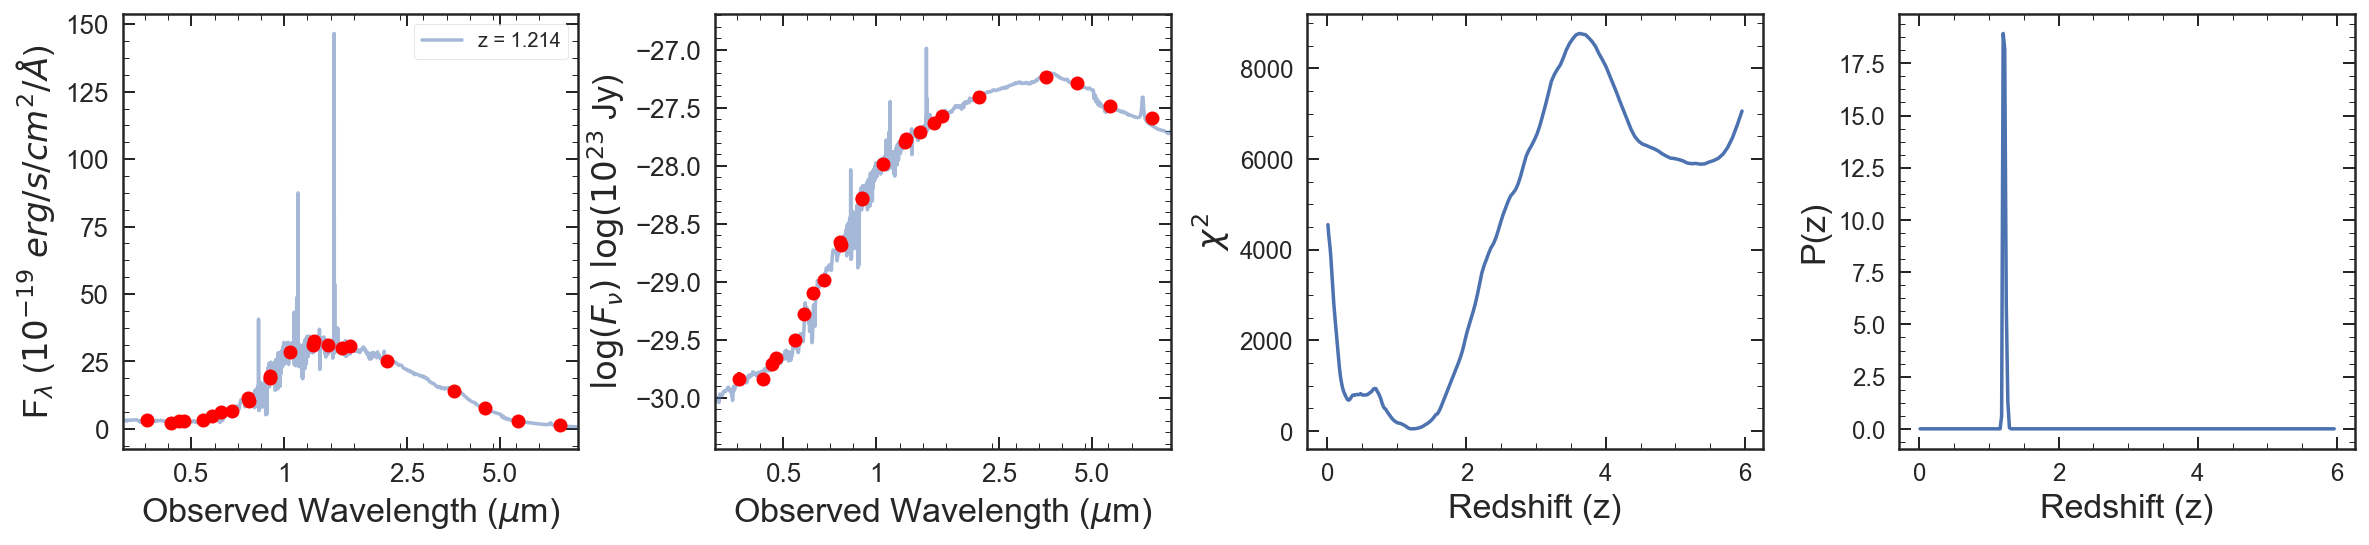

In [67]:
Generate_plot('GN1', 21156)